# Image Regression

Age prediction

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os

In [3]:
image_folder = r'D:\dataset\utkcropped\utkcropped'
image_files = sorted(os.listdir(image_folder))
print(image_files[:3])
print(len(image_files))

['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg']
23706


In [4]:
ages = [float(filename.split('_')[0]) for filename in image_files]
print(ages[:3])

[100.0, 100.0, 100.0]


(200, 200, 3)


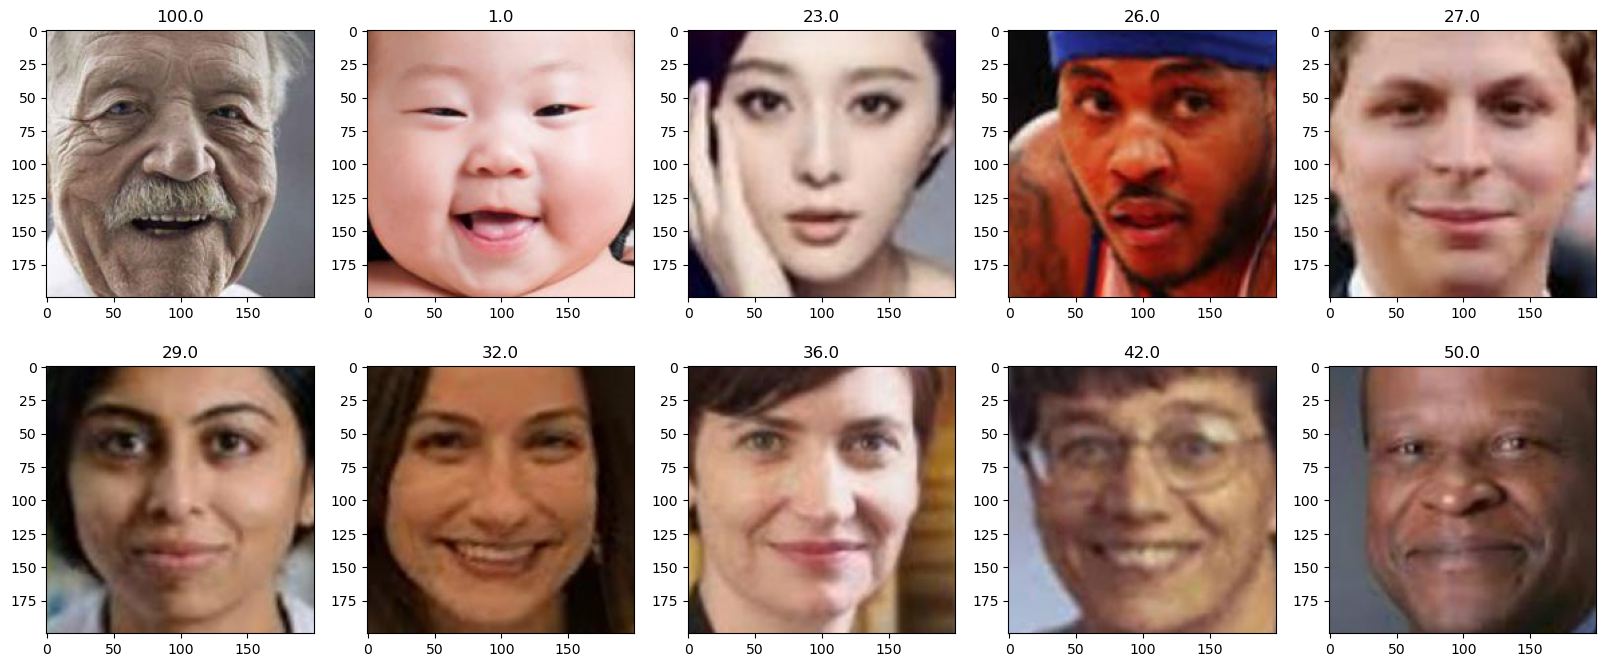

In [6]:

plt.figure(figsize=(20, 8))

for ii in range(10):
    idx = 2000*ii
    image = np.array(Image.open(os.path.join(image_folder, image_files[idx]))).astype(int)
    #image = np.moveaxis(image, -1, 0)
    plt.subplot(2, 5, ii+1)
    plt.imshow(image)
    plt.title(ages[idx])
    
print(image.shape)

### Dataset Class

In [7]:

class AgeDataset(Dataset):
    def __init__(self, image_paths, ages, transform=None):
        self.image_paths = image_paths
        self.ages = ages
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        age = self.ages[idx]
        image = np.array(Image.open(img_path)).astype(float)
        #image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # age is a float target
        age = torch.tensor(age, dtype=torch.float32)
        
        return image, age


### Model Definition

In [8]:

def create_age_prediction_model():
    # Use a pre-trained ResNet50
    base_model = models.resnet50(pretrained=True)
    # Replace the final classification layer with a regression head
    in_features = base_model.fc.in_features
    base_model.fc = nn.Linear(in_features, 1)
    return base_model


### Train Test Split 

In [59]:

random.seed(10)

image_paths = [os.path.join(image_folder, imgf) for imgf in image_files]
total_num = len(image_paths)
train_idx = sorted(random.sample([i for i in range(total_num)], k=int(0.7*total_num)))
print(len(train_idx))

16594


In [10]:
test_idx = sorted(list(set([i for i in range(total_num)]) - set(train_idx)))
print(len(test_idx))

7112


In [11]:

# --------------------------
# Example Training Script
# --------------------------

# Example image paths and ages (you must provide real data)
train_image_paths = [image_paths[idx] for idx in train_idx]
train_ages = [ages[idx] for idx in train_idx]
    
val_image_paths = [image_paths[idx] for idx in test_idx]
val_ages = [ages[idx] for idx in test_idx]
    

In [48]:
img_array = [] 
for i in range(len(image_paths)):
    if i % 5000 == 0:
        print(i)
    img_array.append(np.array(Image.open(os.path.join(image_folder, image_files[i]))).astype(int))
img_array = np.array(img_array)    

0
5000
10000
15000
20000


In [50]:
img_array.shape

(23706, 200, 200, 3)

In [52]:
print(np.mean(img_array, axis=(0, 1, 2))/255, 
      np.std(img_array, axis=(0, 1, 2))/255) 


[0.59609393 0.4563717  0.39062104] [0.25925138 0.23130608 0.22684193]


In [53]:
# Transforms: resize, center crop, and normalize (example values for normalization)
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.596, 0.456, 0.390],
                         [0.259, 0.231, 0.226])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.596, 0.456, 0.390],
                         [0.259, 0.231, 0.226])
])



In [56]:

train_dataset = AgeDataset(train_image_paths, train_ages, transform=train_transform)
val_dataset = AgeDataset(val_image_paths, val_ages, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_age_prediction_model().to(device)
model
    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [57]:
device

device(type='cuda')

In [58]:

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for imgs, ages in train_loader:
            imgs = imgs.to(device)
            ages = ages.to(device).unsqueeze(1)  # shape (B,1)
            
            optimizer.zero_grad()
            preds = model(imgs.float())  # shape (B,1)
            loss = criterion(preds, ages)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for imgs, ages in val_loader:
                imgs = imgs.to(device)
                ages = ages.to(device).unsqueeze(1)
                preds = model(imgs.float())
                loss = criterion(preds, ages)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # After training, save model
    #torch.save(model.state_dict(), "age_prediction_model.pt")


Epoch [1/100] Train Loss: 650.7984, Val Loss: 305.1181
Epoch [2/100] Train Loss: 128.8491, Val Loss: 84.8362
Epoch [3/100] Train Loss: 42.1560, Val Loss: 55.1233
Epoch [4/100] Train Loss: 26.5323, Val Loss: 60.3957
Epoch [5/100] Train Loss: 19.3258, Val Loss: 60.3930
Epoch [6/100] Train Loss: 13.5881, Val Loss: 56.1928
Epoch [7/100] Train Loss: 10.7770, Val Loss: 54.8244
Epoch [8/100] Train Loss: 9.2232, Val Loss: 53.1047
Epoch [9/100] Train Loss: 7.7000, Val Loss: 51.4649
Epoch [10/100] Train Loss: 7.3383, Val Loss: 51.7021
Epoch [11/100] Train Loss: 6.7946, Val Loss: 50.8665
Epoch [12/100] Train Loss: 7.0102, Val Loss: 52.7323
Epoch [13/100] Train Loss: 6.2012, Val Loss: 51.9406
Epoch [14/100] Train Loss: 6.5242, Val Loss: 51.0613
Epoch [15/100] Train Loss: 5.7676, Val Loss: 51.3373
Epoch [16/100] Train Loss: 5.4660, Val Loss: 51.5194
Epoch [17/100] Train Loss: 5.8138, Val Loss: 54.6216
Epoch [18/100] Train Loss: 6.5899, Val Loss: 49.9152
Epoch [19/100] Train Loss: 5.4358, Val Loss: 

KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), "age_prediction_model.pt")

### Inference on Unseen Image

In [38]:

def predict_age(model, img_path, device):
    model.eval()
    transform = transforms.Compose([
        #transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # (1,3,224,224)
    
    with torch.no_grad():
        pred = model(image.float())
    return pred.item()



In [ ]:

for i in range(20):
    print(predict_age(model, val_image_paths[i], device), val_ages[i])


In [ ]:
# Usage:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = create_age_prediction_model().to(device)
# model.load_state_dict(torch.load("age_prediction_model.pt", map_location=device))
# predicted_age = predict_age(model, "path/to/unseen_face.jpg", device)
# print(f"Predicted Age: {predicted_age:.2f}")
